In [1]:
%%capture
from lmi import lmi
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

import time
import os

from sklearn.metrics import roc_auc_score, roc_curve

torch.manual_seed(2121)

In [2]:
pxf = pd.read_csv('../data/ProtT5_embeddings/OP_LR.csv', index_col=0)
ligands = [x for x in pxf.keys() if x[:2] == 'L_']
receptors = [x for x in pxf.keys() if x[:2] == 'R_']

prots = list(set(list(pxf['L UniProt'].values) + list(pxf['R UniProt'].values)))
print('Total proteins: %d' %(len(prots)))

Total proteins: 1702


In [3]:
trials = range(20)

d = {
    'Trial number' : [],
    'TPR' : [],
    'FPR' : [],
    'ROCAUC' : []
}

for T in tqdm(trials):
    
    held_out = np.random.choice(prots, 170)

    train = pxf[(~pxf['L UniProt'].isin(held_out)) & (~pxf['R UniProt'].isin(held_out))]
    val = pxf[(pxf['L UniProt'].isin(held_out)) | (pxf['R UniProt'].isin(held_out))]
    assert len(train) + len(val) == len(pxf), "Something wrong with split"

    # cursed
    train_inds = [pxf.index.get_loc(train.iloc[i].name) for i in range(len(train))]
    val_inds = [pxf.index.get_loc(val.iloc[i].name) for i in range(len(val))]

    held_out_embeddings = {}
    for h in held_out:

        h_is_ligand = pxf[pxf['L UniProt'] == h]
        if len(h_is_ligand) > 0:
            held_out_embeddings[h] = h_is_ligand.iloc[0][ligands].values
        else:
            h_is_r = pxf[pxf['R UniProt'] == h]
            held_out_embeddings[h] = h_is_r.iloc[0][receptors].values

    pairs = list(zip(np.repeat(held_out, len(held_out), axis=0),
                       np.tile(held_out, (len(held_out), 1)).flatten()))

    annotations = [p in [tuple(x) for x in pxf[['L UniProt', 'R UniProt']].values] \
                   for p in pairs]

    # print("Training set size: %d" %len(train_inds))

    Xs = pxf[ligands].to_numpy()
    Ys = pxf[receptors].to_numpy()

    Xs = np.nan_to_num((Xs - Xs.mean(axis=0)) / Xs.std(axis=0))
    Ys = np.nan_to_num((Ys - Ys.mean(axis=0)) / Ys.std(axis=0))

    pxf[ligands], pxf[receptors] = Xs, Ys

    Xs, Ys = torch.from_numpy(Xs).float().cuda(), torch.from_numpy(Ys).float().cuda()

    Xs = torch.clip(Xs, min=-10, max=10)
    Ys = torch.clip(Ys, min=-10, max=10)

    Zx, Zy, model = lmi.ae(Xs, Ys, train_inds, val_inds, quiet=True)



    qXs = [held_out_embeddings[h].astype(float) for h in held_out]
    qYs = [held_out_embeddings[h].astype(float) for h in held_out]

    qXs = torch.from_numpy(np.repeat(qXs, len(qXs), axis=0))
    qYs = torch.from_numpy(np.tile(qYs, (len(qYs), 1)))

    qXs = torch.from_numpy(np.nan_to_num((qXs - qXs.mean(axis=0)) 
                                         / qXs.std(axis=0))).float().cuda()
    qYs = torch.from_numpy(np.nan_to_num((qYs - qYs.mean(axis=0)) 
                                         / qYs.std(axis=0))).float().cuda()

    with torch.no_grad():
        qZx, qZy = model.encode(qXs, qYs)
        qZx, qZy = qZx.cpu(), qZy.cpu()

    pred = lmi.ksg.out_of_sample_pmi(Zx, 
                               Zy, 
                               qZx, 
                               qZy)

    fpr, tpr, th = roc_curve(annotations, pred)
    roc_auc = roc_auc_score(annotations, pred)
    
    d['Trial number'] += [T]*len(fpr)
    d['FPR'] += list(fpr)
    d['TPR'] += list(tpr)
    d['ROCAUC'] += [roc_auc]*len(fpr)

  0%|          | 0/20 [00:00<?, ?it/s]

In [4]:
df = pd.DataFrame(d)

(0.0, 1.0)

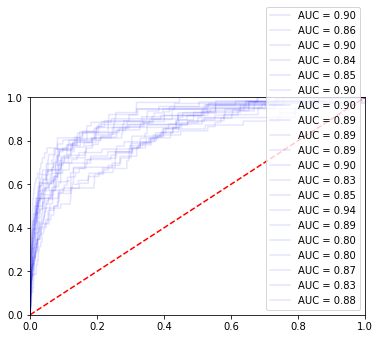

In [5]:
for T in trials:
    fpr = df[df['Trial number'] == T]['FPR']
    tpr = df[df['Trial number'] == T]['TPR']
    roc_auc = df[df['Trial number'] == T]['ROCAUC'].iloc[0]
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc, alpha=0.1)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])

In [6]:
df.to_csv('../results/OP_LR_roc.csv')